In [ ]:
#Disable warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [ ]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Import Dataset
df_sentiment = pd.read_csv('sentiment_twitter_full.csv')
df_positive = df_sentiment[df_sentiment['compound']>0]
df_negative = df_sentiment[df_sentiment['compound']<0]
#df=data[data["text"].str.contains("centralization|decentralization|governance|transparency|privacy|incentives|regualtion|layer two solution|fair launches|transaction|gas fees|listing fees|VC|smart contract|vulnerabilities|oracle|cartels|shills|shitcoin|degen|finance",na=False)]
df_input = df_positive[df_positive['lemmatized'].notna()]

In [ ]:
df_negative.shape

(9955, 9)

In [ ]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df_input.lemmatized.astype(str).values.tolist()
data1 = df_input.text.astype(str).values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])
# [['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', ...trucated...]]

[['see', 'lawsuit', 'trump', 'default', 'behavior', 'reward', 'court']]


In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.035*"new" + 0.026*"help" + 0.025*"price" + 0.019*"support" + 0.015*"year" '
  '+ 0.014*"firm" + 0.014*"asset" + 0.014*"payment" + 0.013*"week" + '
  '0.012*"adoption"'),
 (1,
  '0.085*"report" + 0.025*"token" + 0.021*"security" + 0.018*"industry" + '
  '0.013*"buy" + 0.012*"time" + 0.012*"gain" + 0.010*"improve" + '
  '0.010*"global" + 0.009*"issue"'),
 (2,
  '0.060*"bitcoin" + 0.036*"blockchain" + 0.031*"trading" + 0.029*"market" + '
  '0.025*"join" + 0.019*"trader" + 0.018*"technology" + 0.014*"trade" + '
  '0.014*"future" + 0.013*"world"'),
 (3,
  '0.026*"defi" + 0.024*"live" + 0.023*"user" + 0.018*"high" + 0.018*"launch" '
  '+ 0.017*"platform" + 0.014*"solution" + 0.014*"large" + 0.013*"financial" + '
  '0.013*"value"')]


What is the Dominant topic and its percentage contribution in each document

In [ ]:
df_input.head()

,created_at,tweet_id,text,pre_cleaned,cleaned,lemmatized,scores,compound,polarity_by_mesg
2,11/7/2020 20:03,1.325170e+18,RT @KnightDavidJ: So what we're seeing now wit...,RT So what we re seeing now with these lawsuit...,So seeing lawsuits Trump defaulting behavior r...,see lawsuit trump default behavior reward court,"{'neg': 0.179, 'neu': 0.472, 'pos': 0.349, 'co...",0.4215,0.000000
3,11/7/2020 20:03,1.325170e+18,RT @KnightDavidJ: One of the reasons I left la...,RT One of the reasons I left law is that the s...,One reasons I left law system favors guys like...,reason leave law system favor guy like Trump l...,"{'neg': 0.322, 'neu': 0.389, 'pos': 0.289, 'co...",0.1027,-0.100000
4,11/7/2020 20:01,1.325170e+18,@rezendi @MrSumfing Until individuals become m...,Until individuals become more empowered and en...,Until individuals become empowered enlightened...,individual empower enlighten politic deliver b...,"{'neg': 0.212, 'neu': 0.485, 'pos': 0.303, 'co...",0.1280,-0.177778
6,11/7/2020 19:29,1.325160e+18,"RT @MrSumfing: This, a million times. @lex_nod...",RT This a million times node you are now offic...,This million times node officially centrist Go...,million time node officially centrist God lead...,"{'neg': 0.0, 'neu': 0.58, 'pos': 0.42, 'compou...",0.7003,0.800000
7,11/7/2020 19:18,1.325160e+18,RT @hasufl: The dark secret of generalized pre...,RT The dark secret of generalized prediction m...,The dark secret generalized prediction markets...,dark secret generalize prediction market succe...,"{'neg': 0.0, 'neu': 0.758, 'pos': 0.242, 'comp...",0.4939,-0.275000


In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data1)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.3833,"new, help, price, support, year, firm, asset, ...",RT @KnightDavidJ: So what we're seeing now wit...
1,1,0.0,0.4036,"new, help, price, support, year, firm, asset, ...",RT @KnightDavidJ: One of the reasons I left la...
2,2,2.0,0.4872,"bitcoin, blockchain, trading, market, join, tr...",@rezendi @MrSumfing Until individuals become m...
3,3,1.0,0.4548,"report, token, security, industry, buy, time, ...","RT @MrSumfing: This, a million times. @lex_nod..."
4,4,2.0,0.7148,"bitcoin, blockchain, trading, market, join, tr...",RT @hasufl: The dark secret of generalized pre...
5,5,3.0,0.7251,"defi, live, user, high, launch, platform, solu...","@g3nology I understand. Sometimes ""careful orc..."
6,6,2.0,0.5241,"bitcoin, blockchain, trading, market, join, tr...",@moo9000 I only get optimistic when I think ab...
7,7,0.0,0.5927,"new, help, price, support, year, firm, asset, ...","A philosophy of ""personal sovereignty,"" master..."
8,8,2.0,0.7975,"bitcoin, blockchain, trading, market, join, tr...",It is disturbing that even my smartest friends...
9,9,2.0,0.5845,"bitcoin, blockchain, trading, market, join, tr...",I am very disturbed by the way the country is ...


In [ ]:
df_dominant_topic.to_csv('df_dominant_topic.csv')

The most representative sentence for each topic

In [ ]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9414,"new, help, price, support, year, firm, asset, payment, week, adoption","Univalent — me, @kaiynne, @StaniKulechov, @AndreCronjeTech — just voted YES on @UniswapProtocol ..."
1,1.0,0.9385,"report, token, security, industry, buy, time, gain, improve, global, issue","@jabbers4live Everything I've done in Bitcoin has been ""spreading my politics"".\n\nIt's just tha..."
2,2.0,0.9415,"bitcoin, blockchain, trading, market, join, trader, technology, trade, future, world","@joel_john95 @pridesai @LambdaSchool Ok this part I can get behind ser. ""Both are weird, and one..."
3,3.0,0.9488,"defi, live, user, high, launch, platform, solution, large, financial, value","@SchmiegSophie For sure, but you can still do von Neumann-style tricks to extract maximal entrop..."


In [ ]:
sent_topics_sorteddf_mallet.to_csv("representative_topic.csv")

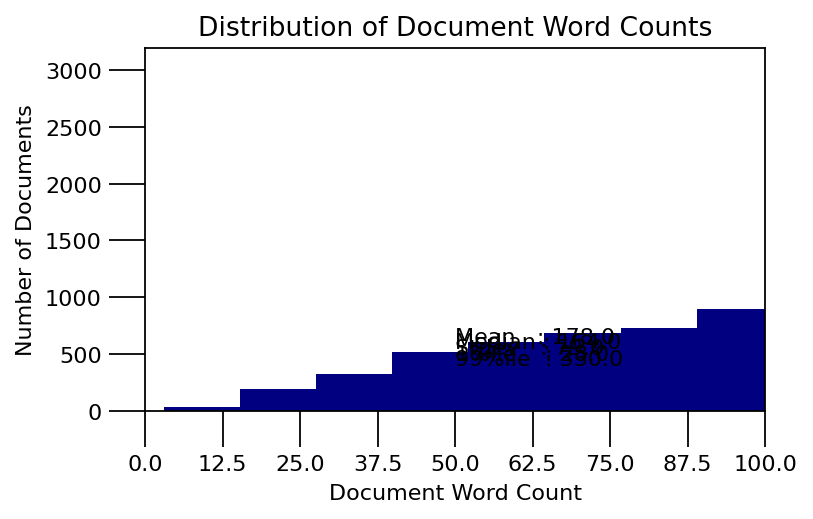

In [ ]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(5,3), dpi=160)
plt.hist(doc_lens, bins = 50, color='navy')
plt.text(50, 600, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(50, 550, "Median : " + str(round(np.median(doc_lens))))
plt.text(50, 500, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(50, 450, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(50, 400, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 100), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,100,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=12))
plt.show()

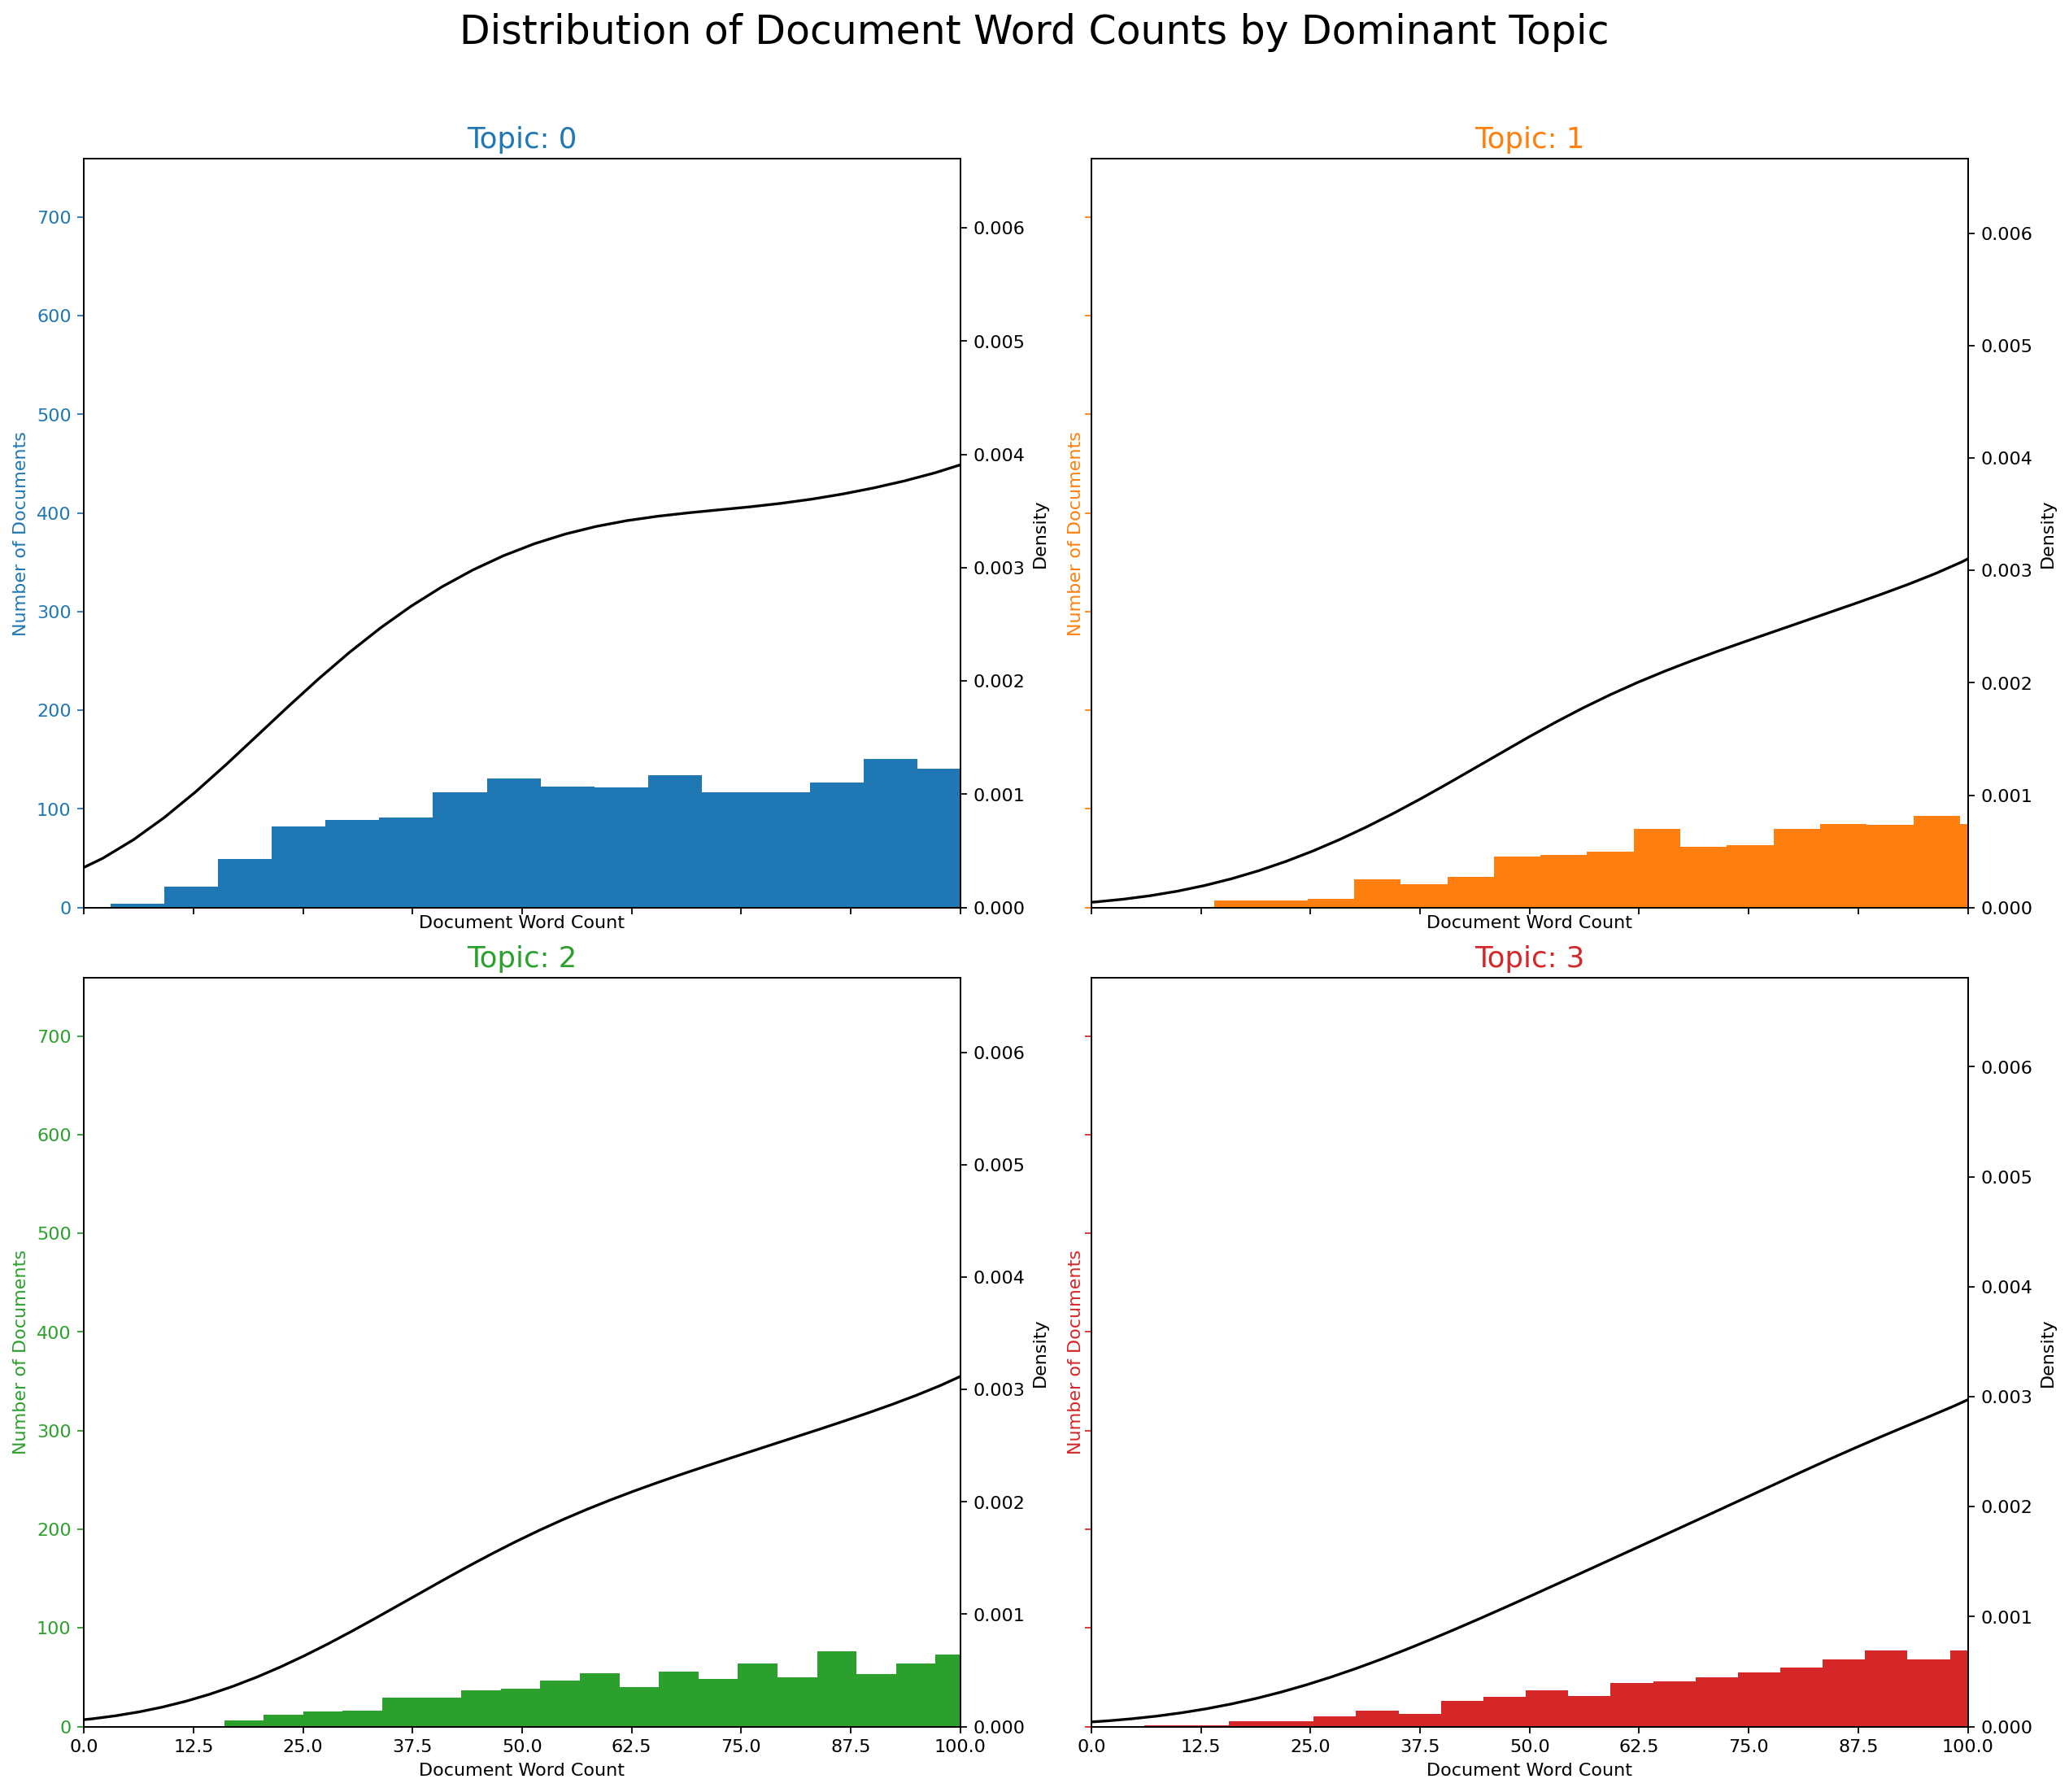

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 100, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 100), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,100,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

Word Clouds of Top N Keywords in Each Topic

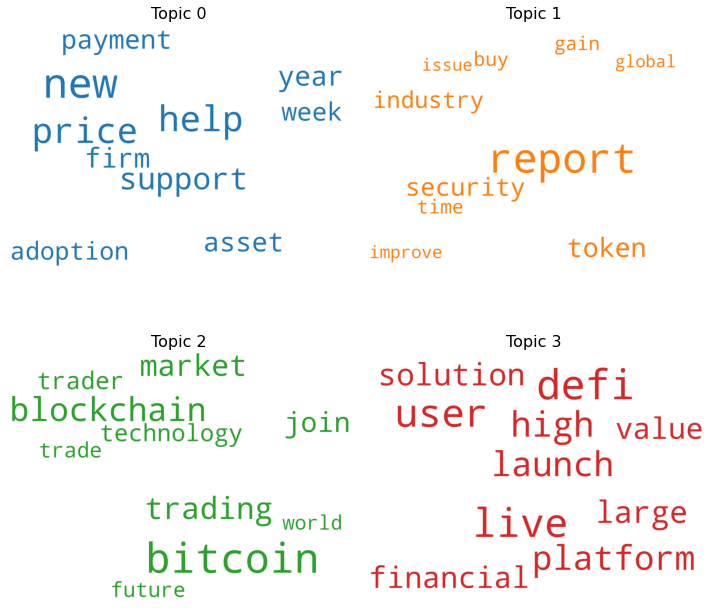

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Word Clouds of Top N Keywords in Each Topic

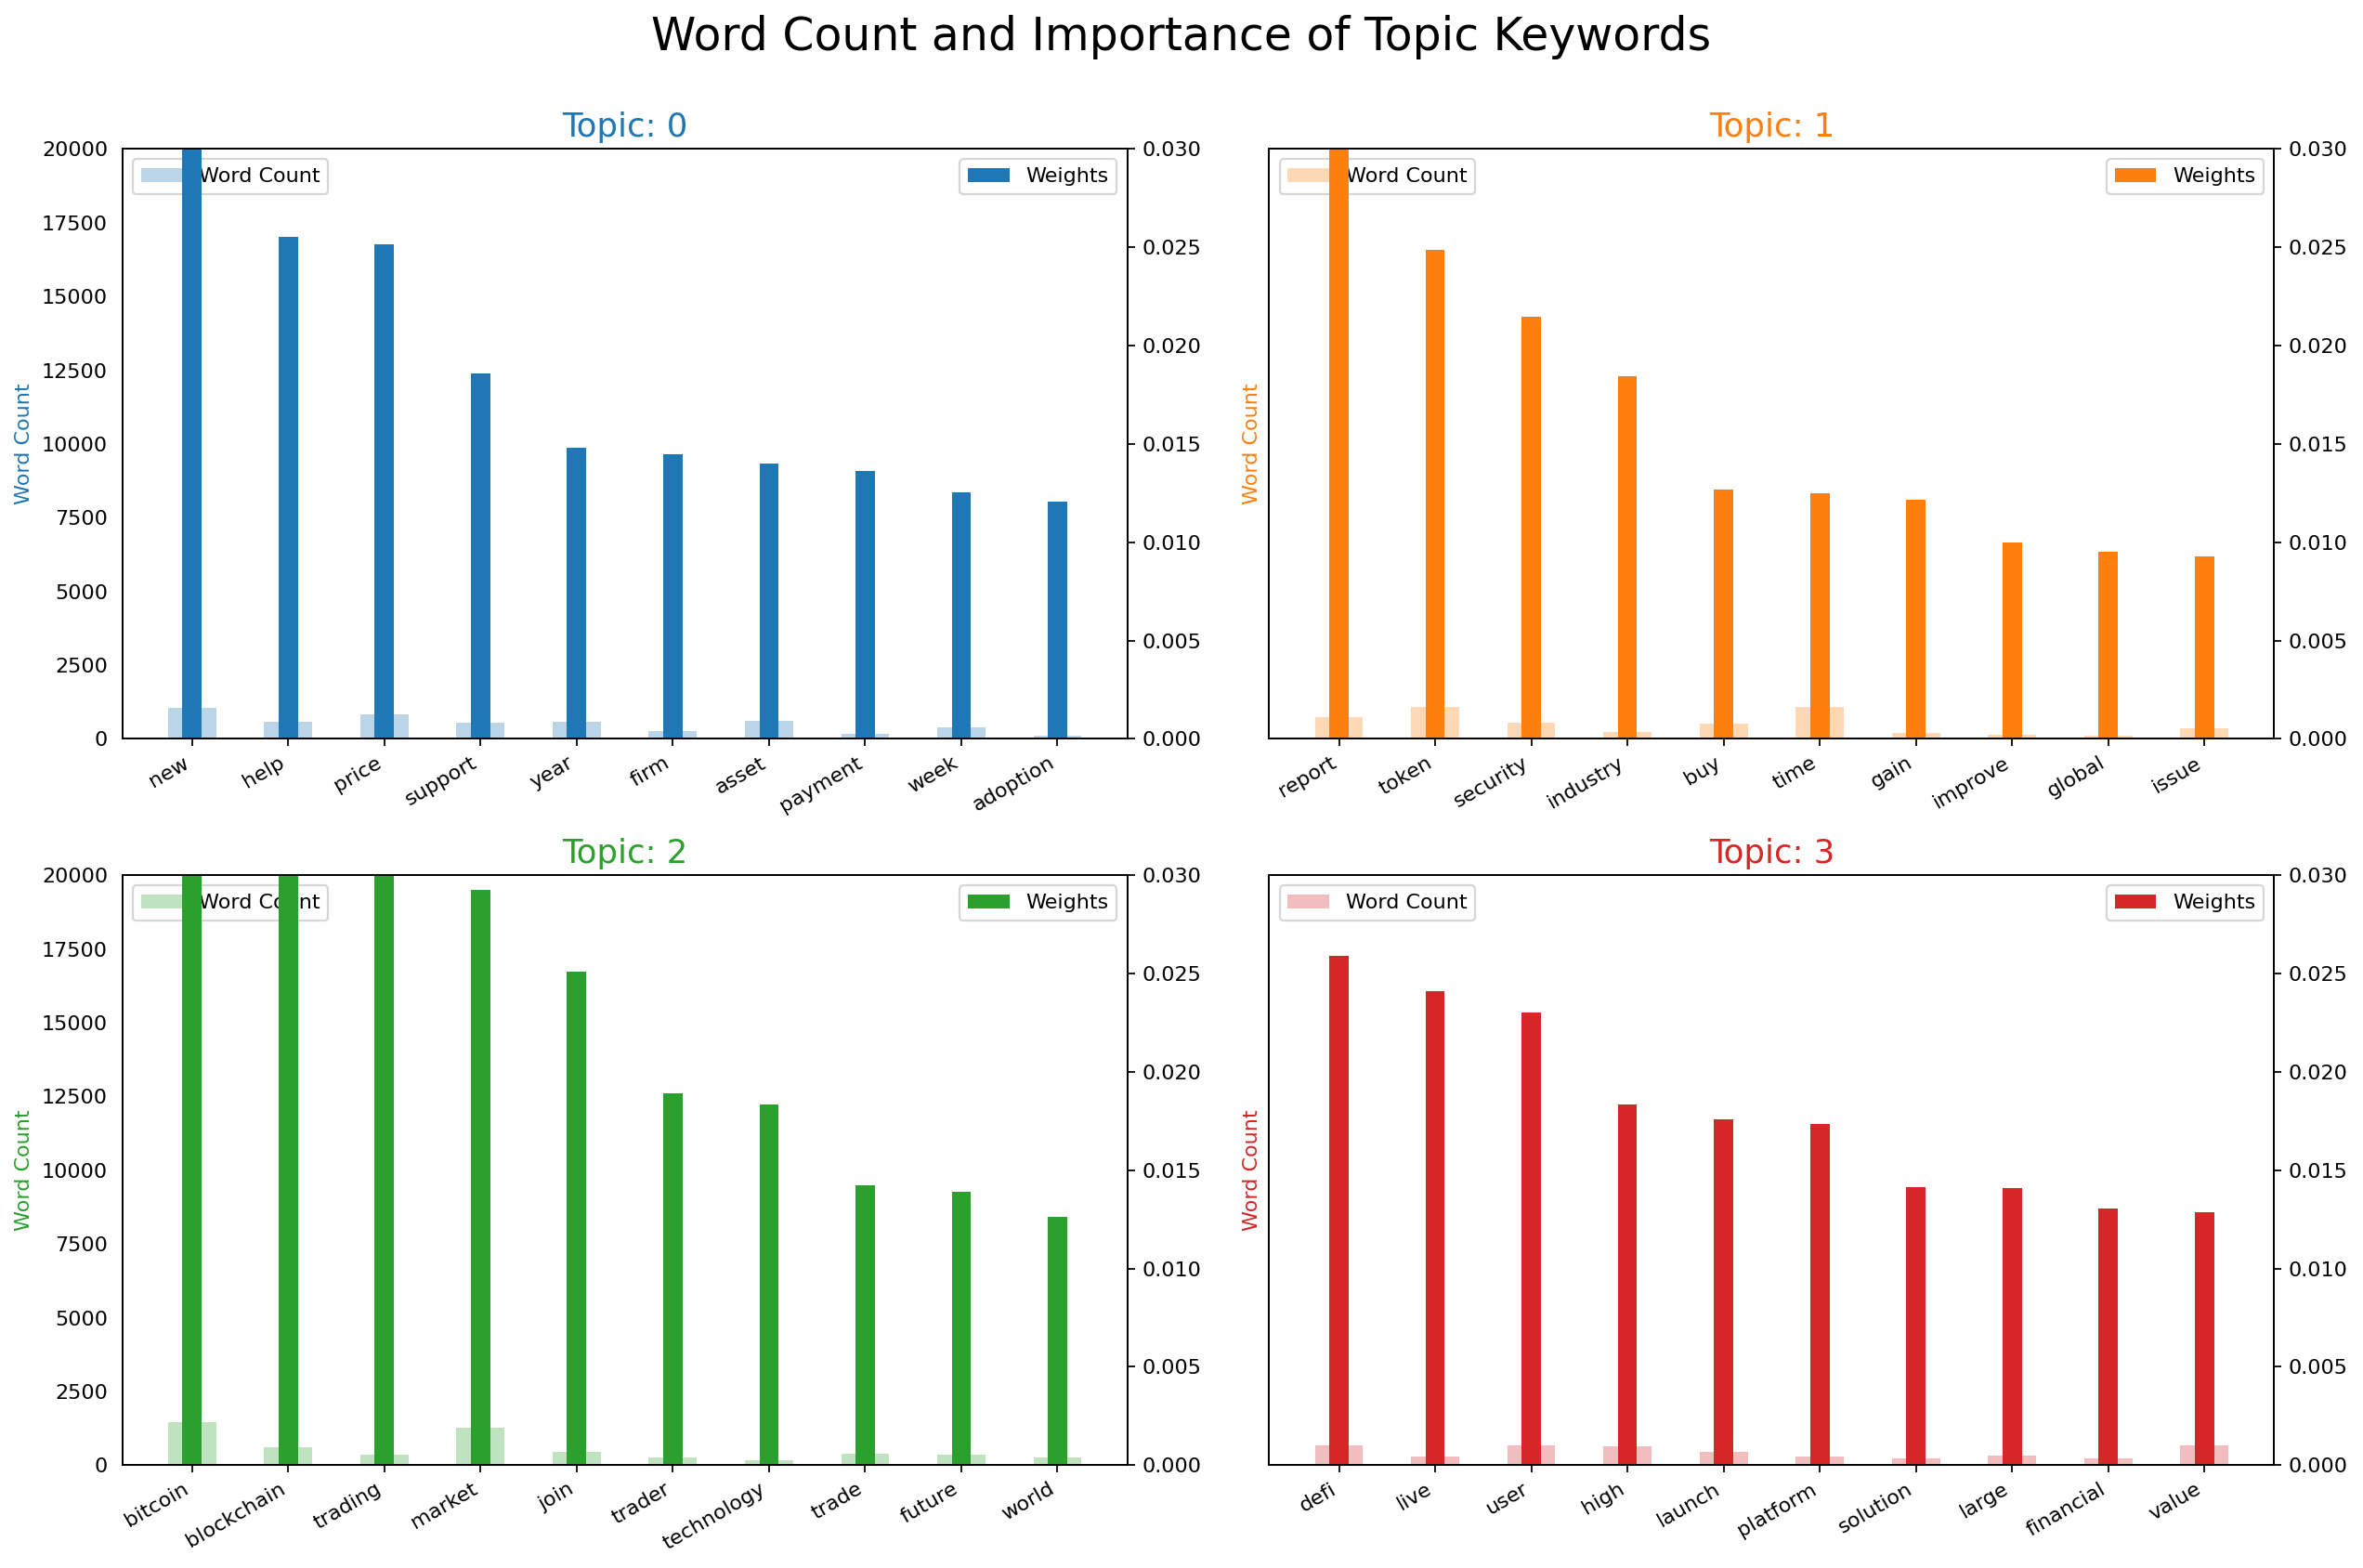

In [ ]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 20000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

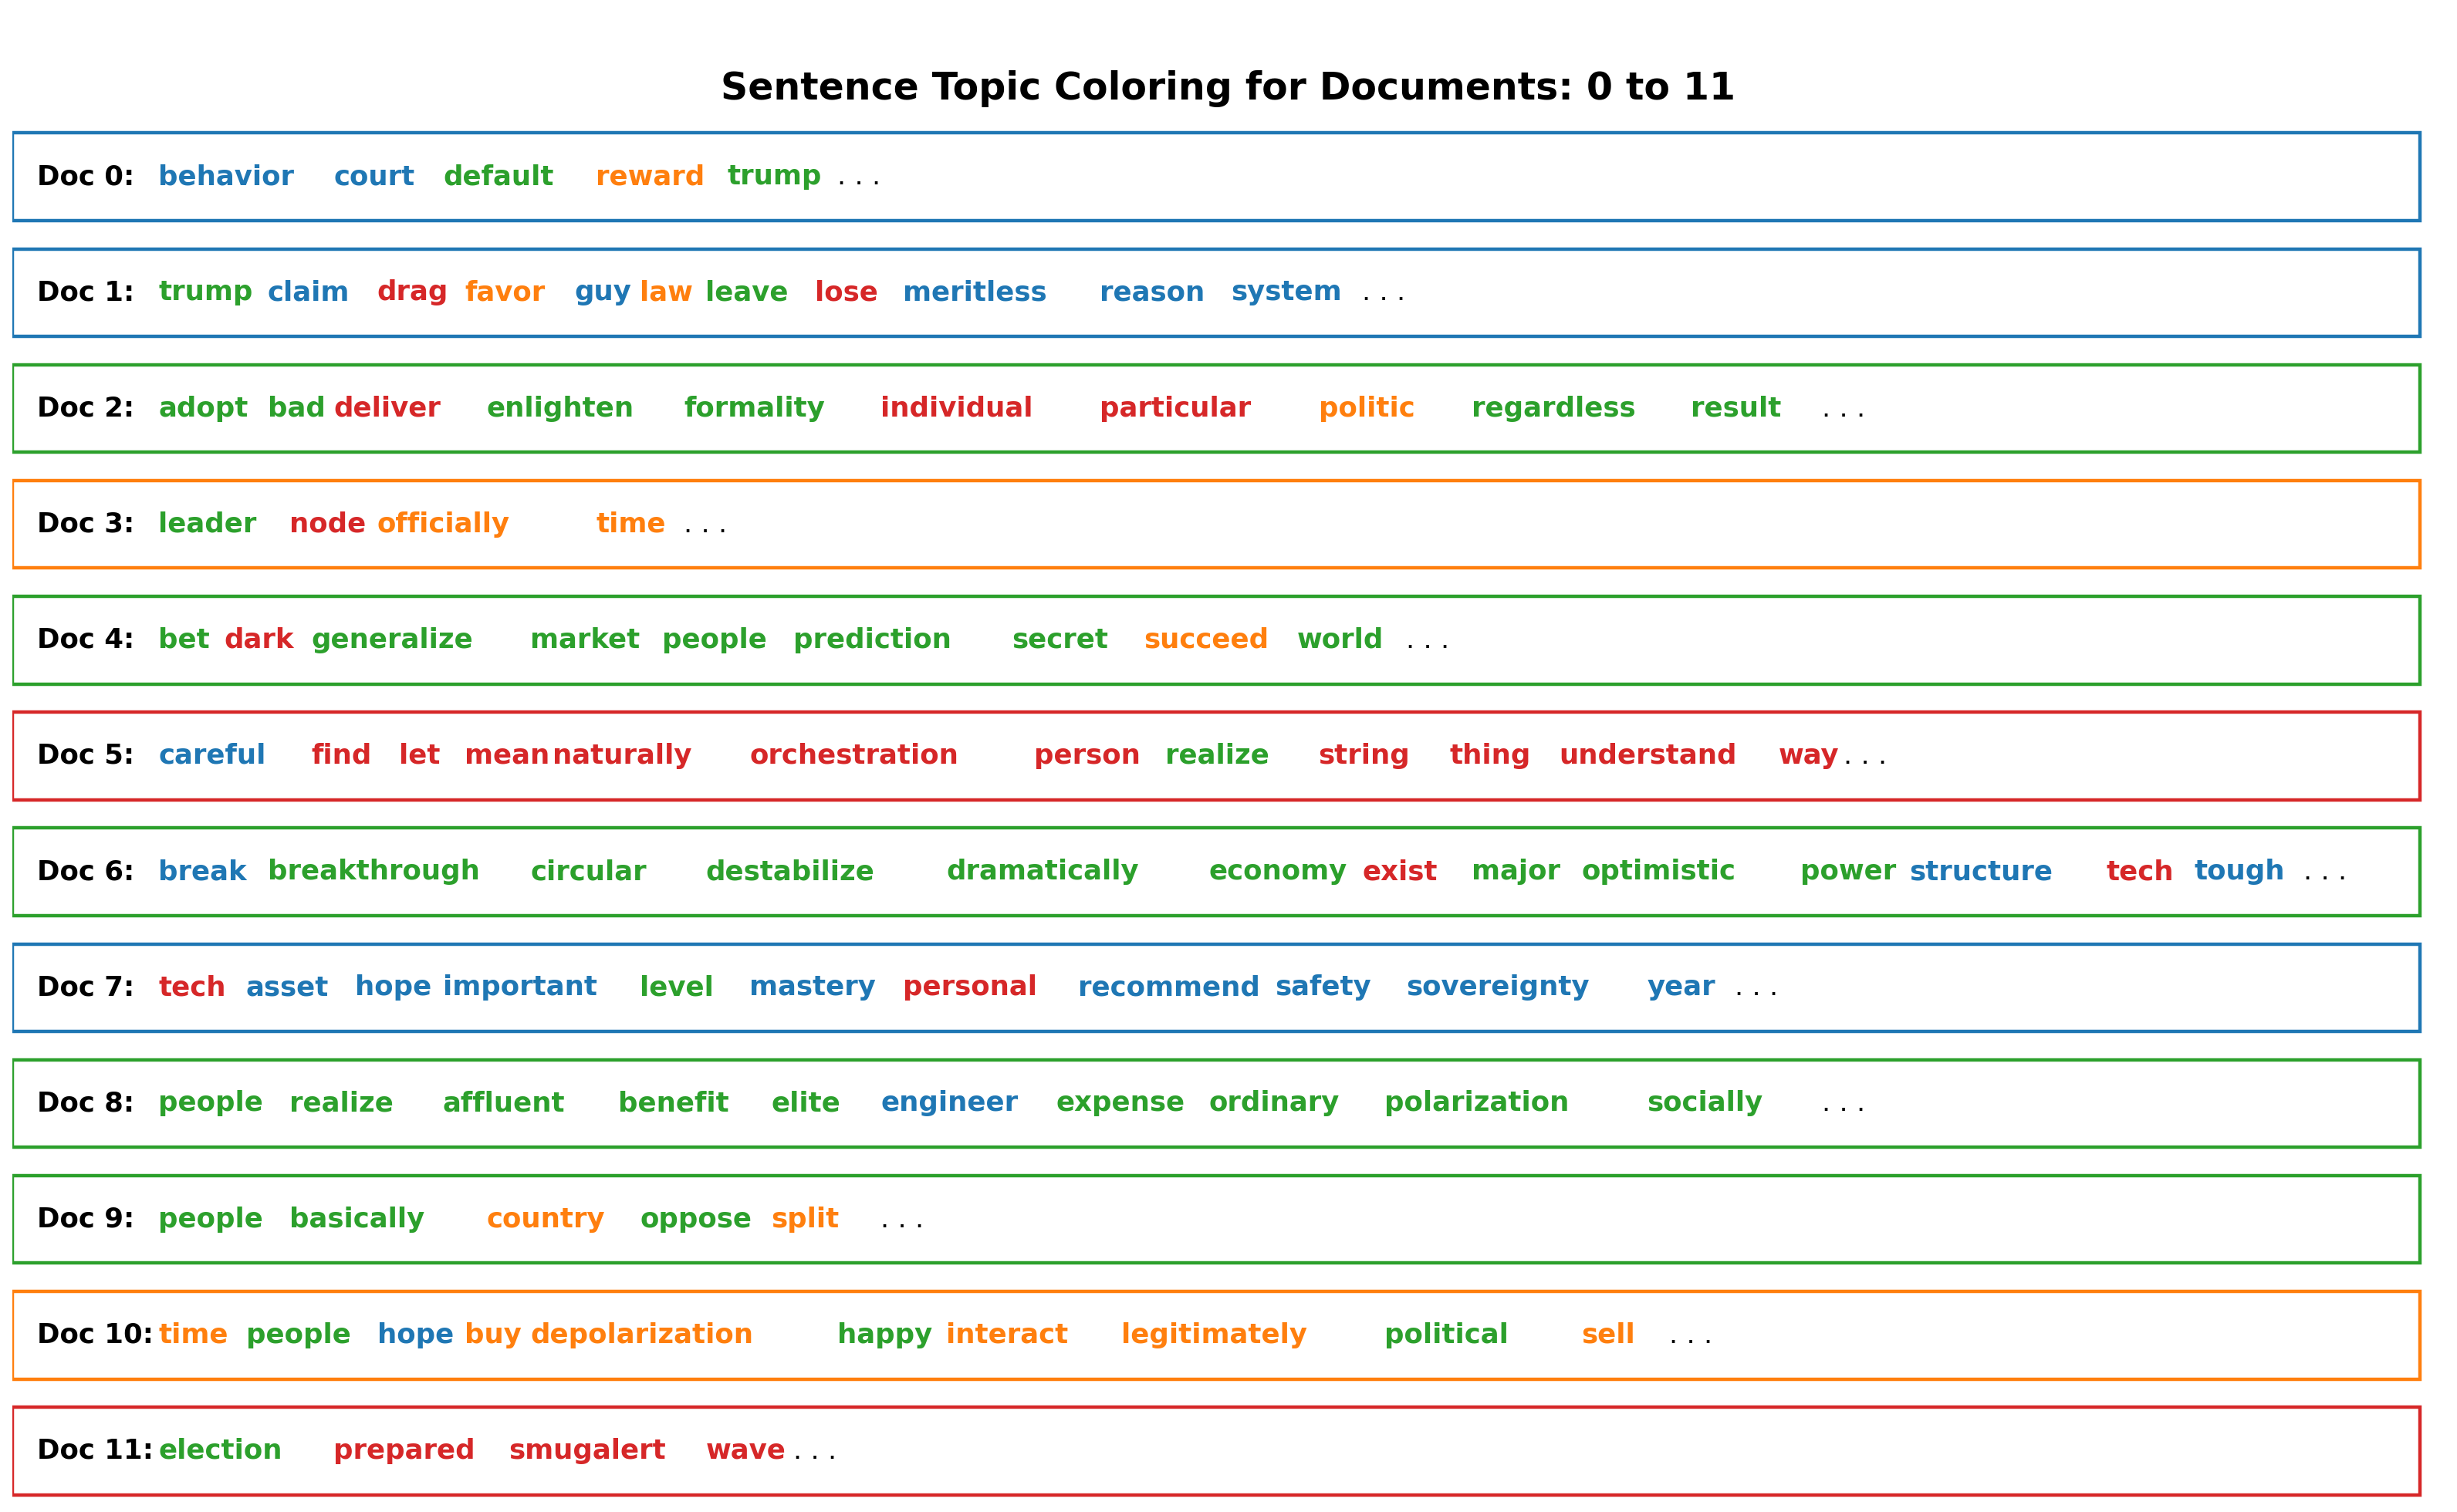

In [ ]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

In [ ]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

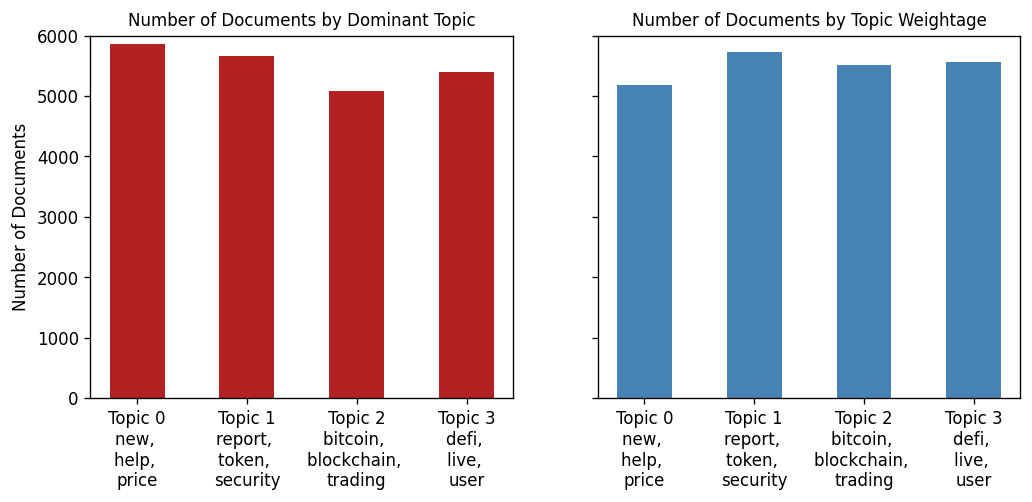

In [ ]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 6000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [ ]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 18759 samples in 0.014s...
[t-SNE] Computed neighbors for 18759 samples in 0.542s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18759
[t-SNE] Computed conditional probabilities for sample 2000 / 18759
[t-SNE] Computed conditional probabilities for sample 3000 / 18759
[t-SNE] Computed conditional probabilities for sample 4000 / 18759
[t-SNE] Computed conditional probabilities for sample 5000 / 18759
[t-SNE] Computed conditional probabilities for sample 6000 / 18759
[t-SNE] Computed conditional probabilities for sample 7000 / 18759
[t-SNE] Computed conditional probabilities for sample 8000 / 18759
[t-SNE] Computed conditional probabilities for sample 9000 / 18759
[t-SNE] Computed conditional probabilities for sample 10000 / 18759
[t-SNE] Computed conditional probabilities for sample 11000 / 18759
[t-SNE] Computed conditional probabilities for sample 12000 / 18759
[t-SNE] Computed conditional probabilities for sam

In [ ]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 6.9MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=a52fd412281e2bc852cabdd3ab1ab23ce40c82e92d0bfb3b760f49ba25ef11c3
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.347464  0.010463       1        1  26.180613
3     -0.129273  0.248163       2        1  25.987412
2     -0.109737 -0.308617       3        1  24.881780
0     -0.108453  0.049991       4        1  22.950195, topic_info=            Term         Freq        Total Category  logprob  loglift
2908      report  3997.000000  3997.000000  Default  30.0000  30.0000
193      bitcoin  2695.000000  2695.000000  Default  29.0000  29.0000
149   blockchain  1607.000000  1607.000000  Default  28.0000  28.0000
257          new  1462.000000  1462.000000  Default  27.0000  27.0000
1132     trading  1375.000000  1375.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
388         plan   252.962145   253.884307   Topic4  -5.0933   1.4682
5          claim   251.880185   252.804512   Topic4  -5.0976   1.4682
1376      remain   275.049030   276.132527   Topic4  -5.0096   1.4679
604         rise   254.300066   255.252114   Topic4  -5.0880   1.4681
1672     suggest   259.595693   261.250094   Topic4  -5.0674   1.4655

[157 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3213      4  0.999031  adoption
178       4  0.996962     allow
1426      3  0.995738       art
63        4  0.997533     asset
1217      2  0.995809      bank
...     ...       ...       ...
49        2  0.998362       way
1637      4  0.997293      week
288       4  0.998630      work
37        3  0.997621     world
72        4  0.997735      year

[135 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1])

In [ ]:
pyLDAvis.save_html(vis, 'lda.html')